In [1]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import os
import matplotlib.pyplot as plt

In [1]:
import cv2

In [3]:
!pip install opencv-python


  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


In [2]:
import numpy as np
from skimage.feature import hog
from skimage import exposure
import os
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path

# Define the base directory

base_dir=Path("chest_xray")

train_d=Path("chest_xray/train")
test_d=Path("chest_xray/test")
val_d=Path("chest_xray/val")



In [4]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [10]:
!pip install tensorflow

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)


     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/390.3 MB 9.9 MB/s eta 0:00:40
   ---------------------------------------- 0.3/390.3 MB 9.9 MB/s eta 0:00:40
   ---------------------------------------- 0.4/390.3 MB 2.9 MB/s eta 0:02:16
   ---------------------------------------- 0.5/390.3 MB 3.0 MB/s eta 0:02:09
   ---------------------------------------- 0.5/390.3 MB 3.0 MB/s eta 0:02:09
   ---------------------------------------- 0.7/390.3 MB 2.9 MB/s eta 0:02:16
   ---------------------------------------- 0.8/390.3 MB 2.8 MB/s eta 0:02:22
   ---------------------------------------- 1.5/390.3 MB 4.2 MB/s eta 0:01:33
   ---------------------------------------- 1.5/390.3 MB 4.3 MB/s eta 0:01:31
   ---------------------------------------- 2.0/390.3 MB 4.5 MB/s eta 0:01:

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          
    shear_range=0.2,           
    zoom_range=0.2,           
    horizontal_flip=True       
)

# Flow training images in batches of 32 from the directory
train_generator = train_datagen.flow_from_directory(
    train_d,                 
    target_size=(150, 150),     
    batch_size=32,              
    class_mode='binary',
    color_mode='grayscale'         
)

Found 5216 images belonging to 2 classes.


In [7]:
print(train_generator.class_indices)


{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
# for test and val data , we will apply only normalization to ensure that data remains constant and realistic for evaluation

In [8]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
val_generator = val_test_datagen.flow_from_directory(
    val_d,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

Found 16 images belonging to 2 classes.


In [10]:
test_generator = val_test_datagen.flow_from_directory(
    test_d,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

Found 624 images belonging to 2 classes.


For our Chest X-ray pneumonia detection project, since we're not using deep learning (which automatically learns features through convolutional layers), we need to manually extract meaningful features from the images for traditional machine learning models like SVM, Random Forest, Logistic Regression, and K-Nearest Neighbors (KNN).

Considering the nature of X-ray images and the goal of detecting pneumonia, we are going to use HOG as a feature extraction technique. These methods focuses on edges and gradients, which could help identify structural differences in the lungs, especially when differentiating between normal lungs and pneumonia-affected lungs.

HOG operates by breaking an image down into small regions, calculating the gradients within those regions, and summarizing the information in histograms. The histograms are then concatenated into a feature vector, which can be used as input for machine learning models.

In [11]:
import os
import numpy as np
from skimage.feature import hog
from skimage import exposure


In [12]:
from sklearn.preprocessing import LabelEncoder

Function to extract HOG features from a batch of images

In [13]:
def apply_hog_to_image(image_path):
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file path.")
    image = cv2.resize(image, (128, 128))  # Resize to 128x128 pixels

   
    hog_features, _ = hog(image,
                          pixels_per_cell=(8,8),
                          cells_per_block=(2,2),
                          orientations=9,
                          block_norm='L2-Hys',
                          visualize=True,
                          feature_vector=True)
         
    return hog_features

In [14]:
train_generator.reset()

In [15]:
def extract_hog_features_from_dataset(folder_path):
    hog_features_list = []
    labels_list = []
    
    # Loop through each subfolder (i.e., the classes NORMAL, PNEUMONIA)
    for label_folder in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label_folder)
        
        if not os.path.isdir(label_path):
            continue  # Skip if not a directory
        
        # Loop through each image file in the folder
        for filename in os.listdir(label_path):
            
                
            image_path = os.path.join(label_path, filename)
            
            # Apply HOG to the image
            try:
                hog_features = apply_hog_to_image(image_path)
                hog_features_list.append(hog_features)
                labels_list.append(label_folder)  # Assuming folder name is the label
            except ValueError as e:
                print(e)  # Log the error, but continue processing
            
    return np.array(hog_features_list), np.array(labels_list)


In [16]:
X_train, y_train = extract_hog_features_from_dataset(train_d)
X_test, y_test = extract_hog_features_from_dataset(test_d)
X_val, y_val = extract_hog_features_from_dataset(val_d)

Failed to load image at chest_xray\train\NORMAL\.DS_Store. Please check the file path.
Failed to load image at chest_xray\train\PNEUMONIA\.DS_Store. Please check the file path.
Failed to load image at chest_xray\val\NORMAL\.DS_Store. Please check the file path.
Failed to load image at chest_xray\val\PNEUMONIA\.DS_Store. Please check the file path.


In [17]:
from collections import Counter
print("Class distribution:", Counter(y_train))


Class distribution: Counter({'PNEUMONIA': 3875, 'NORMAL': 1341})


In [16]:
print(f"Train HOG features shape: {X_train.shape}")
print(f"Test HOG features shape: {X_test.shape}")
print(f"Validation HOG features shape: {X_val.shape}")



Train HOG features shape: (5216, 8100)
Test HOG features shape: (624, 8100)
Validation HOG features shape: (16, 8100)


In [18]:
print(f"Train HOG features shape: {y_train.shape}")
print(f"Test HOG features shape: {y_test.shape}")
print(f"Validation HOG features shape: {y_val.shape}")



Train HOG features shape: (5216,)
Test HOG features shape: (624,)
Validation HOG features shape: (16,)


In [19]:
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

In [20]:
from sklearn.preprocessing import LabelEncoder

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Check the mapping
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


In [21]:
from sklearn.preprocessing import StandardScaler

# Scale the HOG features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


In [24]:
print("Class distribution:", Counter(y_train_balanced))

Class distribution: Counter({'NORMAL': 1341, 'PNEUMONIA': 1341})


Support Vector Machine

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize an SVM classifier
svm_model = SVC(kernel='linear', random_state=42)

# Train the model
svm_model.fit(X_train_scaled, y_train_encoded)




SVC(kernel='linear', random_state=42)

In [28]:
# Make predictions on the train set
y_train_pred = svm_model.predict(X_train_scaled)

# Evaluate the model
print("Train Accuracy:", accuracy_score(y_train_encoded, y_train_pred))

Train Accuracy: 1.0


In [31]:
# Make predictions on the validation set
y_test_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
print("Test Accuracy:", accuracy_score(y_test_encoded, y_test_pred))
print("Classification Report:\n", classification_report(y_test_encoded, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_test_pred))
print("Classification Report:\n", classification_report(y_test_encoded, y_test_pred))

Test Accuracy: 0.7724358974358975
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.42      0.58       234
           1       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.81      0.77      0.74       624

Confusion Matrix:
 [[ 98 136]
 [  6 384]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.42      0.58       234
           1       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.81      0.77      0.74       624



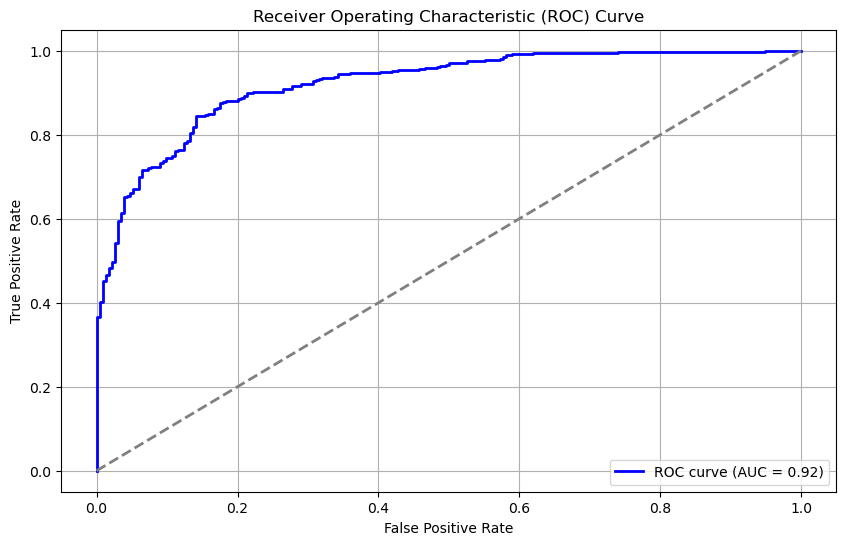

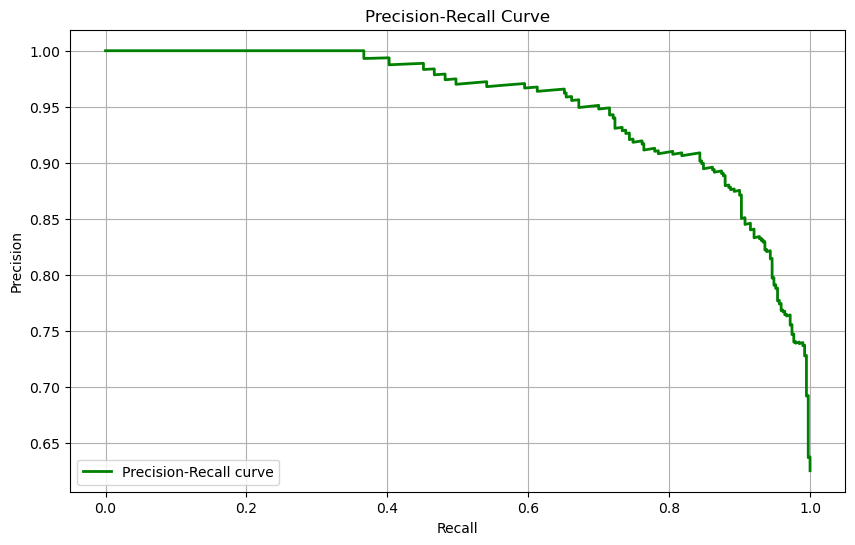

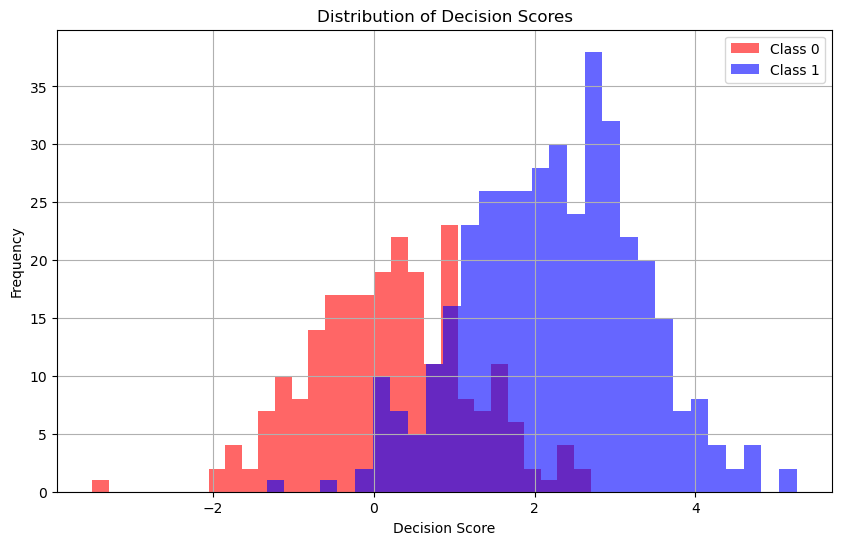

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay

# Predict probabilities for ROC and Precision-Recall curves
y_test_proba = svm_model.decision_function(X_test_scaled)  # Decision function for SVM

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test_encoded, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test_encoded, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Distribution Curve
plt.figure(figsize=(10, 6))
plt.hist(y_test_proba[y_test_encoded == 0], bins=30, alpha=0.6, label="Class 0", color='red')
plt.hist(y_test_proba[y_test_encoded == 1], bins=30, alpha=0.6, label="Class 1", color='blue')
plt.title("Distribution of Decision Scores")
plt.xlabel("Decision Score")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.grid()
plt.show()


In [67]:
import joblib

# Save the model
joblib.dump(svm_model, 'hog_svm_model.pkl')

# To load it later
# loaded_model = joblib.load('hog_svm_model.pkl')


['hog_svm_model.pkl']

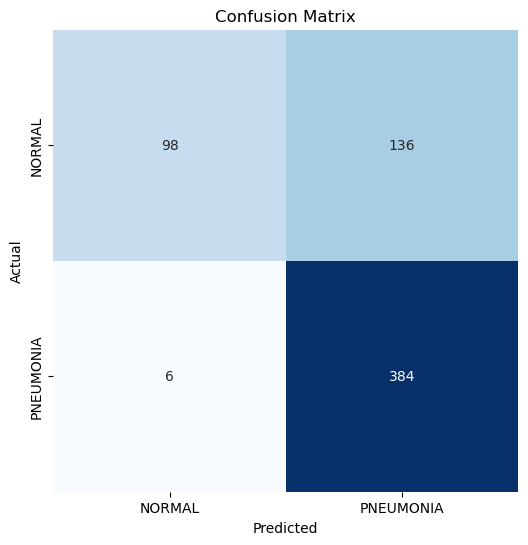

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.94      0.42      0.58       234
   PNEUMONIA       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.81      0.77      0.74       624



In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Make predictions on the validation set
y_test_pred = svm_model.predict(X_test_scaled)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_test_encoded, y_test_pred)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Step 4: Print classification report
print("Classification Report:\n", classification_report(y_test_encoded, y_test_pred, target_names=['NORMAL', 'PNEUMONIA']))


Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the training data
log_reg_model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000, random_state=42)

In [47]:
y_train_pred_log_reg = log_reg_model.predict(X_train_balanced)

# Calculate training accuracy
train_accuracy_log_reg = accuracy_score(y_train_balanced, y_train_pred_log_reg)

print(f"Training Accuracy: {train_accuracy_log_reg * 100:.2f}%")

Training Accuracy: 100.00%


In [48]:


# Make predictions on the test data
y_pred = log_reg_model.predict(X_test)


In [49]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [50]:
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 78.04%


Confusion Matrix for Logistic Regression:

[[102 132]
 [  5 385]]


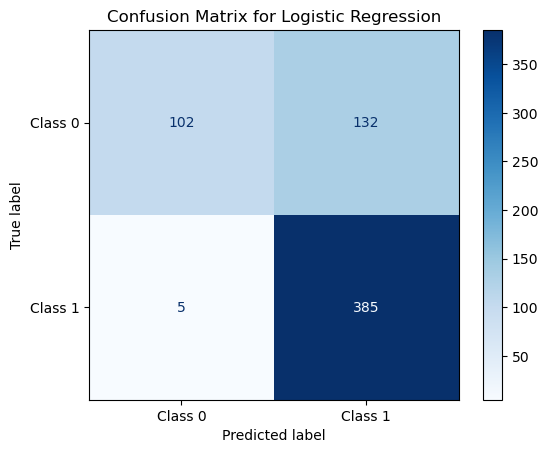

In [65]:
log_reg_confusion_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix for Logistic Regression:\n")
print(log_reg_confusion_matrix)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=log_reg_confusion_matrix, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues", values_format="d")  # Format as integers
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

In [51]:
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.44      0.60       234
   PNEUMONIA       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.85      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



K-nearest neighbour

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors for better results

# Train the model
knn_model.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier()

In [52]:
y_train_pred_knn = knn_model.predict(X_train_balanced)


In [54]:
# Calculate training accuracy
train_accuracy_knn = accuracy_score(y_train_balanced, y_train_pred_knn)
print(f"Training Accuracy (KNN): {train_accuracy_knn * 100:.2f}%")

Training Accuracy (KNN): 95.04%


In [57]:
y_test_pred_knn = knn_model.predict(X_test_scaled)

# Calculate test accuracy
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print(f"Test Accuracy (KNN): {test_accuracy_knn * 100:.2f}%")


Test Accuracy (KNN): 80.61%


In [59]:
knn_classification_report = classification_report(y_test, y_test_pred_knn, target_names=["Class 0", "Class 1"])
print("Classification Report for KNN:\n")
print(knn_classification_report)

Classification Report for KNN:

              precision    recall  f1-score   support

     Class 0       0.84      0.59      0.70       234
     Class 1       0.79      0.93      0.86       390

    accuracy                           0.81       624
   macro avg       0.82      0.76      0.78       624
weighted avg       0.81      0.81      0.80       624



Confusion Matrix for KNN:

[[139  95]
 [ 26 364]]


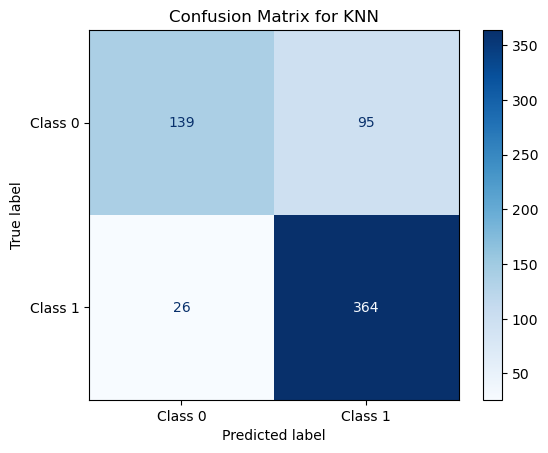

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
knn_confusion_matrix = confusion_matrix(y_test, y_test_pred_knn)

# Print the confusion matrix
print("Confusion Matrix for KNN:\n")
print(knn_confusion_matrix)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=knn_confusion_matrix, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues", values_format="d")  # Format as integers
plt.title("Confusion Matrix for KNN")
plt.show()

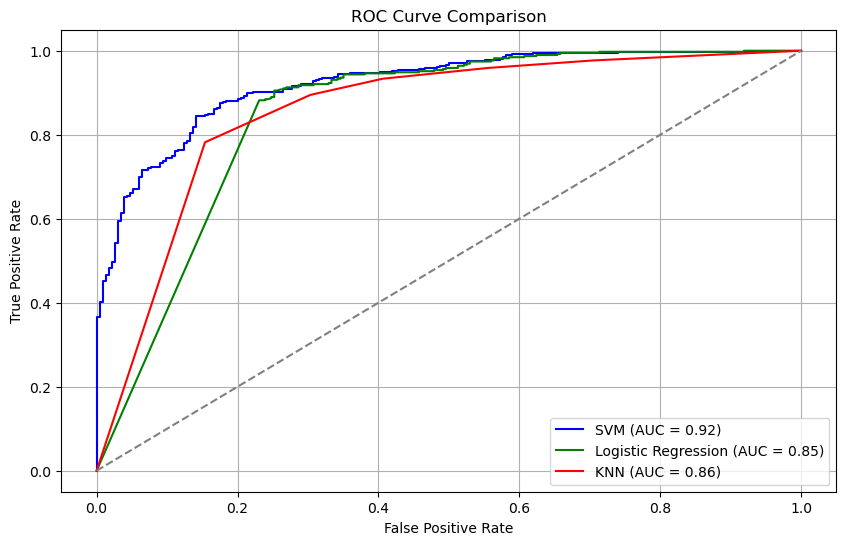

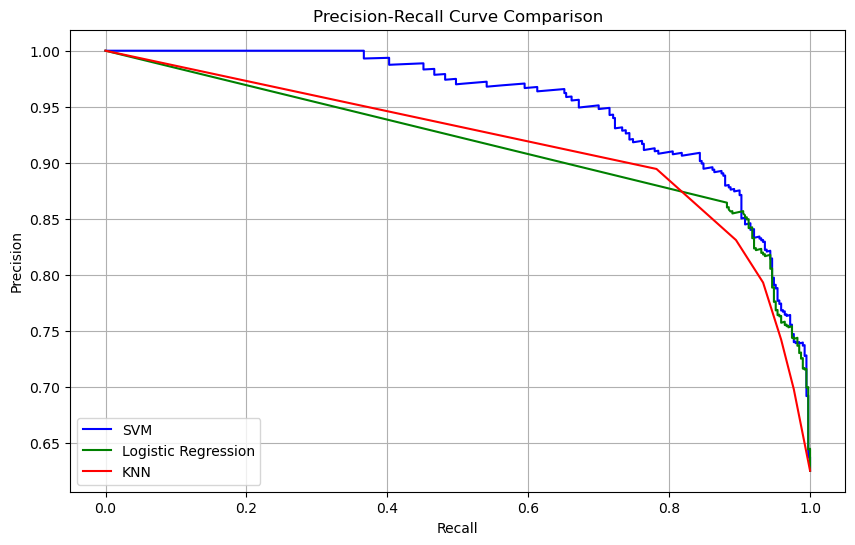

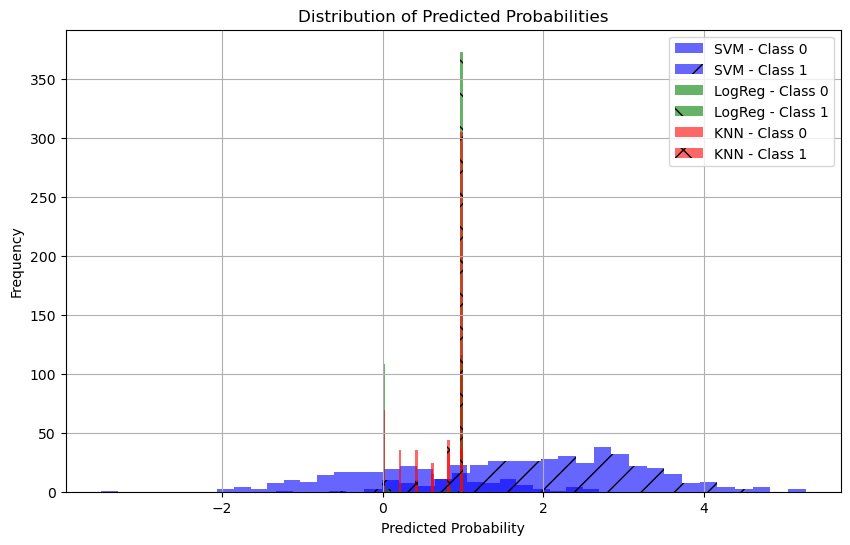

In [58]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Function to calculate ROC and PR metrics for a given model
def calculate_metrics(model, X_test, y_test):
    # Predict probabilities if possible, otherwise use decision function
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        raise ValueError("Model does not support predict_proba or decision_function")
    
    # ROC curve metrics
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall curve metrics
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    return fpr, tpr, roc_auc, precision, recall, y_proba

# Calculate metrics for SVM
fpr_svm, tpr_svm, roc_auc_svm, precision_svm, recall_svm, y_proba_svm = calculate_metrics(svm_model, X_test_scaled, y_test_encoded)

# Calculate metrics for Logistic Regression
fpr_lr, tpr_lr, roc_auc_lr, precision_lr, recall_lr, y_proba_lr = calculate_metrics(log_reg_model, X_test_scaled, y_test_encoded)

# Calculate metrics for KNN
fpr_knn, tpr_knn, roc_auc_knn, precision_knn, recall_knn, y_proba_knn = calculate_metrics(knn_model, X_test_scaled, y_test_encoded)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.2f})", color='blue')
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", color='green')
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {roc_auc_knn:.2f})", color='red')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_svm, precision_svm, label="SVM", color='blue')
plt.plot(recall_lr, precision_lr, label="Logistic Regression", color='green')
plt.plot(recall_knn, precision_knn, label="KNN", color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="lower left")
plt.grid()
plt.show()

# Plot Distribution Curve
plt.figure(figsize=(10, 6))
plt.hist(y_proba_svm[y_test_encoded == 0], bins=30, alpha=0.6, label="SVM - Class 0", color='blue')
plt.hist(y_proba_svm[y_test_encoded == 1], bins=30, alpha=0.6, label="SVM - Class 1", color='blue', hatch='/')
plt.hist(y_proba_lr[y_test_encoded == 0], bins=30, alpha=0.6, label="LogReg - Class 0", color='green')
plt.hist(y_proba_lr[y_test_encoded == 1], bins=30, alpha=0.6, label="LogReg - Class 1", color='green', hatch='\\')
plt.hist(y_proba_knn[y_test_encoded == 0], bins=30, alpha=0.6, label="KNN - Class 0", color='red')
plt.hist(y_proba_knn[y_test_encoded == 1], bins=30, alpha=0.6, label="KNN - Class 1", color='red', hatch='x')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend(loc="upper right", fontsize=10)
plt.grid()
plt.show()
